# $ \text{Raport - Symulacje komputerowe}  $
### $\text{Jakub Ciągło (275986)}$
### $\text{Mateusz Ćwiek (276011)}$
___

### $ \text{Importy} $

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from scipy.stats import norm
from scipy.special import lambertw
import math
import pandas as pd
import timeit
import time

___
# $\text{Zadanie 1 - Generator liczb pseudolosowych ACORN}$

Generator ACORN k-tego rzędu oparty jest na ciągach liczbowych zdefiniowanych poprzez równania rekurencyjne:

$$
X^0_n = X^0_{n-1}, \quad n \geq 1
$$

$$
X^m_n = (X^{m-1}_n + X^m_{n-1}) \mod M, \quad m = 1, \ldots, k, \quad n \geq 1
$$

$$
Y^k_n = \frac{X^k_n}{M}, \quad n \geq 1
$$

Jeśli ziarno (pierwszy element wektora o elementach $X^m_0 \in \{0, \ldots, M\}$, czyli $X^0_0 \in \{1, \ldots, M-1\}$, jest względnie pierwsze z $M$ oraz $M$ jest dostatecznie dużą liczbą naturalną, to generator posiada pożądane cechy a ciąg $Y^k_n$ dla $n \geq 1$ przypomina ciąg IID zmiennych losowych z rozkładu jednostajnego $U(0, 1)$. 




Funkcja `gcd(a, b)` oblicza największy wspólny dzielnik (GCD) dwóch liczb `a` i `b` za pomocą algorytmu Euklidesa. Jest używana do sprawdzenia, czy ziarno (seed) jest względnie pierwsze względem $M$.

In [271]:
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

Implementujemy funkcję `ACORN(N, k, M, Lag, seed)`.

In [272]:
def ACORN(N, k, M, Lag, seed):
    assert gcd(seed, M) == 1, "Seed must be relatively prime to M"

    X = np.zeros((N + Lag, k + 1), dtype=object)
    
    X[0, 0] = seed
    
    for n in range(1, N + Lag):
        X[n, 0] = X[n - 1, 0] 
        for m in range(1, k + 1):
            X[n, m] = (X[n - 1, m - 1] + X[n - 1, m]) % M  
    
    Y = np.array([X[i, k] / M for i in range(Lag, N + Lag)])  # Y^k_n = X^k_n / M for n >= Lag
    
    return Y

In [273]:
N = 1000
k = 9
M = 2**89 - 1
Lag = 1000
seed = 1234567

Sprawdzamy poprawność wyników tworząc wykresy ciągu $Y^k_n$, funkcji $Y^k_{n-1} \rightarrow Y^k_n$ oraz histogramy. Porównujemy także wyniki z wbudowanym generatorem numpy.

ACORN generation time: 0.024244 seconds
Numpy generation time: 0.000000 seconds


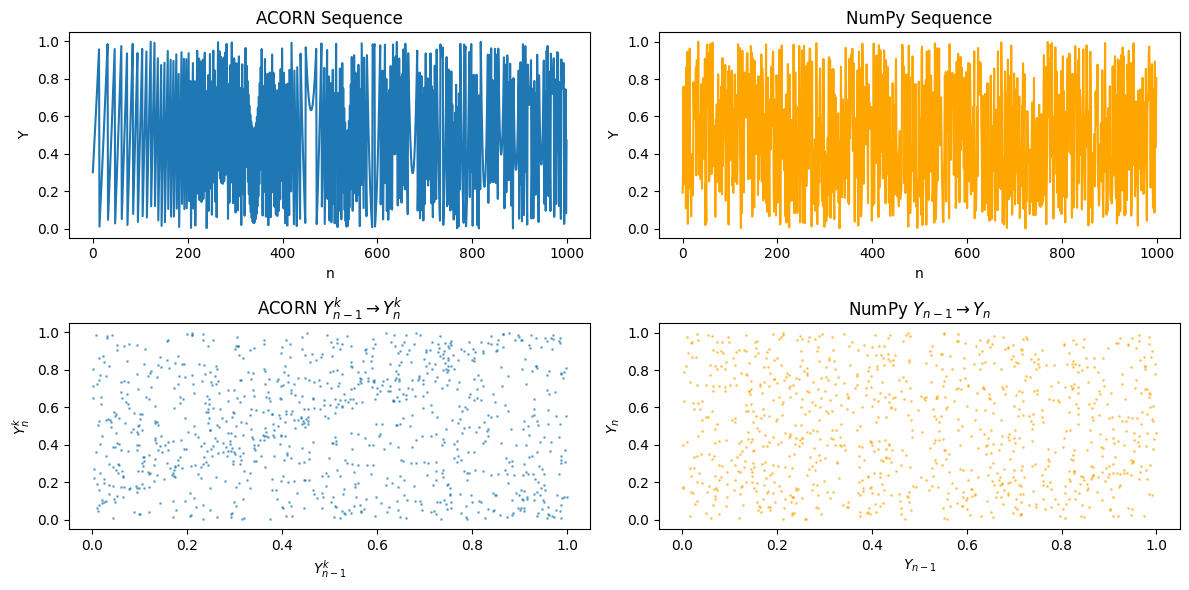

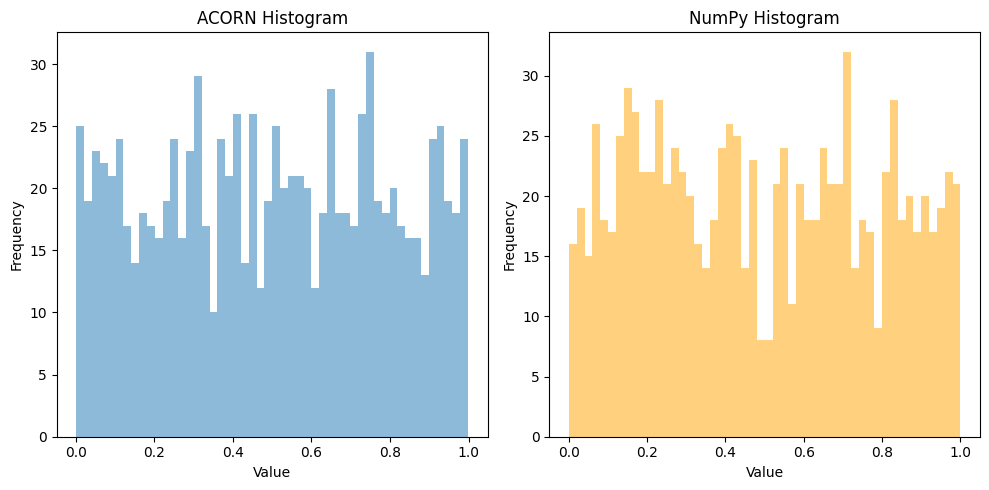

In [274]:
start_time = time.time()
random_numbers_acorn = ACORN(N, k, M, Lag, seed)
acorn_time = time.time() - start_time

start_time = time.time()
numpy_random_numbers = np.random.random(N)
numpy_time = time.time() - start_time

print(f"ACORN generation time: {acorn_time:.6f} seconds")
print(f"Numpy generation time: {numpy_time:.6f} seconds")

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot the sequence of Y_n^k for ACORN
axs[0, 0].plot(random_numbers_acorn, label='ACORN Generated Numbers')
axs[0, 0].set_title('ACORN Sequence')
axs[0, 0].set_xlabel('n')
axs[0, 0].set_ylabel('Y')

# Plot the sequence of Y_n^k for NumPy
axs[0, 1].plot(numpy_random_numbers, label='NumPy Generated Numbers', color='orange')
axs[0, 1].set_title('NumPy Sequence')
axs[0, 1].set_xlabel('n')
axs[0, 1].set_ylabel('Y')

# Plot the function Y_{n-1}^k -> Y_n^k for ACORN
axs[1, 0].scatter(random_numbers_acorn[:-1], random_numbers_acorn[1:], alpha=0.5, s=1)
axs[1, 0].set_title('ACORN $Y_{n-1}^k \\rightarrow Y_n^k$')
axs[1, 0].set_xlabel('$Y_{n-1}^k$')
axs[1, 0].set_ylabel('$Y_n^k$')

# Plot the function Y_{n-1} -> Y_n for NumPy
axs[1, 1].scatter(numpy_random_numbers[:-1], numpy_random_numbers[1:], alpha=0.5, s=1, color='orange')
axs[1, 1].set_title('NumPy $Y_{n-1} \\rightarrow Y_n$')
axs[1, 1].set_xlabel('$Y_{n-1}$')
axs[1, 1].set_ylabel('$Y_n$')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms of ACORN and numpy-generated random numbers
axs[0].hist(random_numbers_acorn, bins=50, alpha=0.5, label='ACORN')
axs[0].set_title('ACORN Histogram')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(numpy_random_numbers, bins=50, alpha=0.5, label='Numpy', color='orange')
axs[1].set_title('NumPy Histogram')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Wnioski

#### ACORN Sequence
- Sekwencja generowana przez algorytm ACORN jest jednorodna i rozłożona równomiernie w przedziale $[0, 1]$.
- Brak widocznych wykładniczych wzorców lub oscylacji, które mogłyby sugerować problemy z losowością.
- Wartości wyglądają na dobrze rozproszone, co jest oczekiwanym zachowaniem dla liczb pseudolosowych.

#### ACORN $Y_{n-1}^{k}$ &#8594; $Y_{n}^{k}$
- Wykres pokazuje, że wartości są rozłożone losowo, bez widocznej liniowej zależności między $Y_{n-1}^{k}$, a $Y_{n}^{k}$
- Punkty są rozmieszczone równomiernie, co wskazuje na brak korelacji między kolejnymi wartościami.

### Ogólne wnioski
- Algorytm ACORN, przy odpowiednich parametrach, generuje sekwencje liczb pseudolosowych, które są jednorodne i rozłożone równomiernie, podobnie jak generator liczb pseudolosowych numpy.
- Brak widocznych wzorców lub korelacji w wykresach sekwencji ACORN wskazuje na poprawne działanie algorytmu.
- Zarówno ACORN, jak i numpy generują sekwencje, które spełniają oczekiwania dotyczące losowości i braku korelacji.


___
# $\text{Zadanie 2 - Generowanie rozkładu normalnego}$
W tym zadaniu zaimplementowano różne metody generowania próbek z rozkładu normalnego. Były to metody poznane na zajęciach, podane w poleceniu oraz samodzielnie zaimplementowane. 

 Na początek stworzono funkcję, która pomoże w generowaniu wykresów gęstości i dystrybuant empirycznych, a także w porównaniu ich z teoretycznymi odpowiednikami. 

In [275]:
def plot_pdf_cdf(data, mu=0, sigma=1):
    
    x_theor = np.linspace(min(data), max(data), n)
    y_theor_pdf = norm.pdf(x_theor, mu, sigma)
    y_theor_cdf = norm.cdf(x_theor, mu, sigma)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_theor, y_theor_cdf, label="dystrybuanta teoretyczna", color = 'red')
    sns.ecdfplot(data, label="dystrybuanta empiryczna",linestyle = '--')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x_theor, y_theor_pdf, color="r", label="gęstość teoretyczna")
    sns.histplot(data, kde=True, stat="density", label="gęstość empiryczna")
    plt.legend()
    plt.suptitle(f"Rozkład normalny N({mu}, {sigma})", fontsize=16)
    plt.show()


Następnie wyznaczono wartości $\mu$ oraz $\sigma$, tak aby generowane rozkłady były rozkładami standardowymi. Wyznaczono również wielkość próbki $n$.

In [279]:
mu = 0
sigma = 1
n = 10000

## Pierwszy krok - dotychczasowe oraz samodzielne implementacje 
Pierwszym krokiem było zaimplementowanie generatorów metodami poznanymi na wykładach, laboratoriach oraz samodzielnie wybranych metod poznanych w internecie.

#### 1. Metoda odwrotnej dystrybuanty
Pierwszą poznaną metodą jest metoda odwrotnej dystrybuanty. Poniżej napisano funkcję, która stworzy próbkę rozkładu normalnego.

In [280]:
def normal(mu, sigma, n):
    U = np.random.rand(n)
    Z = norm.ppf(U)
    return mu + sigma * Z

Następnie zmierzono czas generowania próbki oraz stworzono wykres dystybuanty i gęstości.

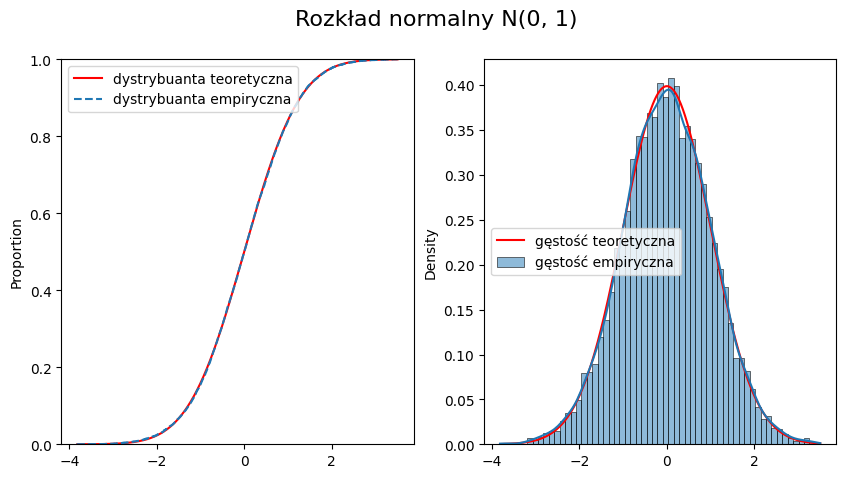

Czas wygenerowania 10000 próbek dla metody odwrtonej dystrybuanty to: 0.0014595999382436275 s


In [281]:
generated_normal = normal(mu, sigma, n)
time1 = timeit.timeit(lambda: normal(mu,sigma,n), number = 1)
plot_pdf_cdf(generated_normal)
print('Czas wygenerowania {} wartości dla metody odwrtonej dystrybuanty to:'.format(n),time1,'s' )

#### 2. Metoda Boxa-Mullera.
Kolejną metodą jest metoda Boxa-Mullera. Na początek napisano funkcję, która wygeneruje wartości z rozkładu normalnego.

In [282]:
def BoxMuller(n):
    U1 = np.random.uniform(0, 1, n)
    U2 = np.random.uniform(0, 1, n)
    factor = np.sqrt(-2 * np.log(U1))
    X = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
    Y = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
    return X, Y

Następnie wygenerowano próbkę wspomnianą metodą, zmierzono czas jej generowania oraz narysowano wykresy dystybuanty oraz gęstości.

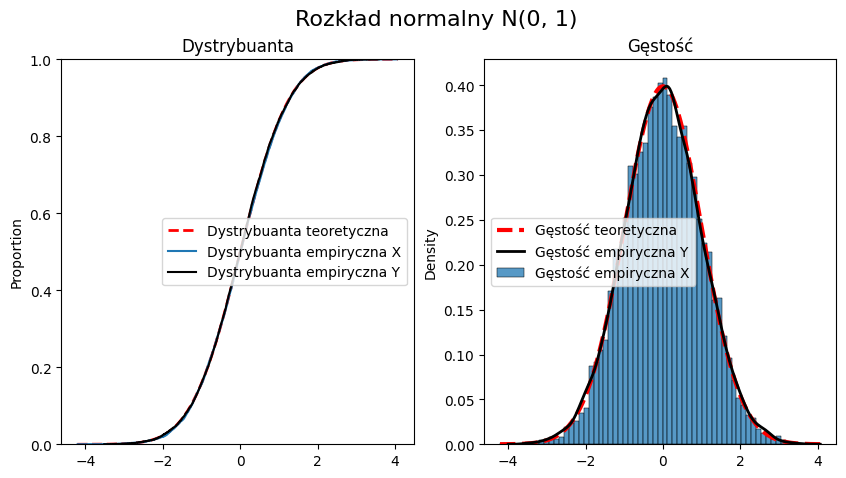

Czas wygenerowania 10000 próbek dla metody Boxa-Mullera to: 0.002529700053855777 s


In [111]:
x1, y1 = BoxMuller(n)
time_box_muller = timeit.timeit(lambda: BoxMuller(n), number = 1)


x_theor = np.linspace(min(np.concatenate([x1, y1])), max(np.concatenate([x1, y1])), n)
y_theor_cdf = norm.cdf(x_theor, 0, 1)
y_theor_pdf = norm.pdf(x_theor, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x1, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y1, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x1, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y1, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()

plt.suptitle(f"Rozkład normalny N({mu}, {sigma})", fontsize=16)
plt.show()
print('Czas wygenerowania {} wartości dla metody Boxa-Mullera to:'.format(n),time_box_muller,'s' )

#### 3. Metoda biegunowa Boxa-Mullera.
Trzecią metodą jest metoda biegunowa Boxa-Mullera. Poniżej napisano funkcję, która zwróci wartości z rozkładu normalnego generowane tą właśnie metodą. 

In [113]:
def polar_BoxMuller(n):
    samples_x = []
    samples_y = []
    while len(samples_x) < n:
        V1 = np.random.uniform(-1, 1)
        V2 = np.random.uniform(-1, 1)
        R2 = V1**2 + V2**2
        if R2 <= 1 and R2 > 0:
            factor = np.sqrt(-2 * np.log(R2) / R2)
            samples_x.append(V1 * factor)
            samples_y.append(V2 * factor)
    return np.array(samples_x), np.array(samples_y)

Następnie wygenerowano próbkę i tak jak w poprzednich przypadkach zmierzono czas generowania i stworzono odpowiednie wykresy. 

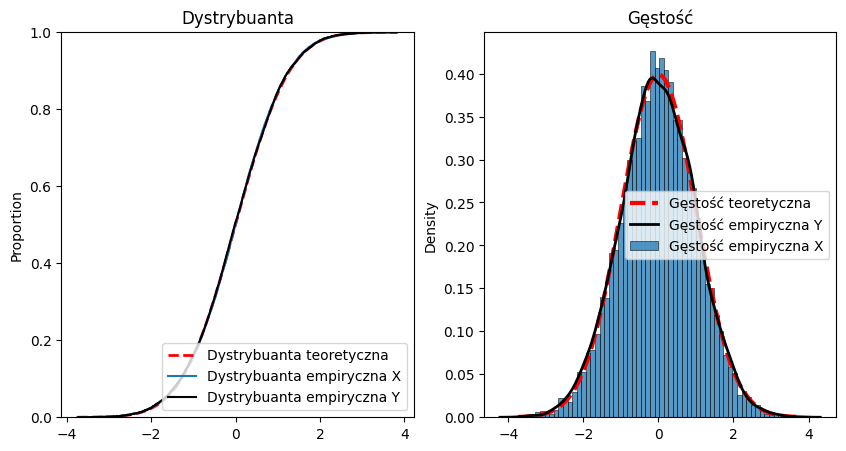

Czas wygenerowania 10000 próbek dla metody biegunowej Boxa-Mullera to: 0.17995169991627336 s


In [114]:
x2, y2 = polar_BoxMuller(n)
time_polar_box_muller = timeit.timeit(lambda: polar_BoxMuller(n), number = 1)


x_theor = np.linspace(min(np.concatenate([x2, y2])), max(np.concatenate([x2, y2])), n)
y_theor_cdf = norm.cdf(x_theor, 0, 1)
y_theor_pdf = norm.pdf(x_theor, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x2, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y2, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x2, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y2, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()
plt.show()

print('Czas wygenerowania {} wartości dla metody biegunowej Boxa-Mullera to:'.format(n),time_polar_box_muller,'s' )

#### 4. Przyspieszony algorytm biegunowej metody, korzystając ze źródła https://quantgirl.blog/comparing-box-muller-and-marsaglia-bray/.
Ostatnią w tym kroku metodą jest przyspieszona metoda biegunowa. Poniżej znajduję się zaimplementowana funkcja, która korzystając z tej metody wygeneruje wartości z rozkładu normalnego.

In [115]:
p = np.pi / 4
aux = p * (1 - p)


def fast_polar_BoxMuller(n):
    x = (3 * math.sqrt(aux) + math.sqrt(9 * aux + p * n)) / p
    N = math.ceil(x * x)

    w1 = np.random.rand(N) * 2 - 1
    w2 = np.random.rand(N) * 2 - 1
    s = w1 * w1 + w2 * w2

    index = s < 1

    w1 = w1[index][:n]
    w2 = w2[index][:n]
    s = s[index][:n]

    t = np.sqrt(-2 * np.log(s) / s)
    z1 = w1 * t
    z2 = w2 * t

    return z1, z2

Następnie wygenerowano próbkę, zmierzono czas, który zajęło jej generowanie oraz stworzono wykresy gęstości i dystrybuanty.

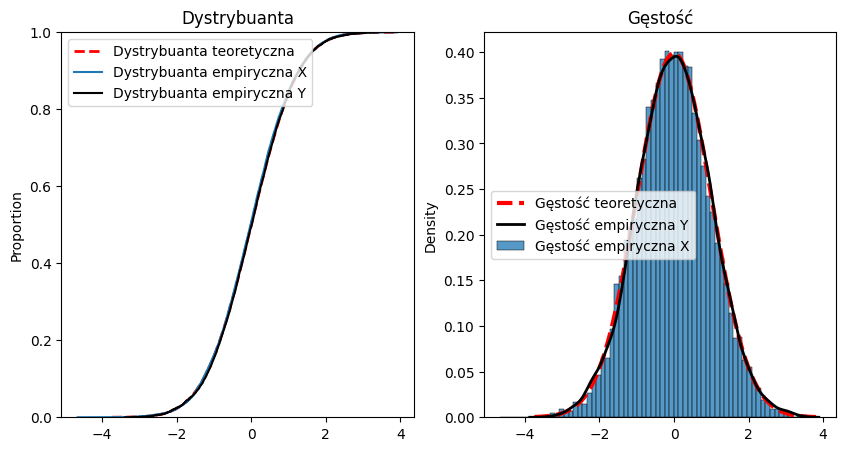

Czas wygenerowania 10000 próbek dla przyspieszonej metody biegunowej Boxa-Mullera to: 0.14958079997450113 s


In [116]:
x3, y3 = fast_polar_BoxMuller(n)
time_fast_box_muller = timeit.timeit(lambda: polar_BoxMuller(n), number = 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x3, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y3, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x3, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y3, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()
plt.show()

print('Czas wygenerowania {} wartości dla przyspieszonej metody biegunowej Boxa-Mullera to:'.format(n),time_fast_box_muller,'s' )

## Drugi krok - dodatkowe metody generowania rozkładu normalnego.
W drugim kroku zaimplementowano dwie dodatkowe metody generowania rozkładu normalnego.

#### 1. Metoda tuzina.
Jako pierwszą zaimplementowano funkcję, ktora generuję rozklad normalny metodą tuzina.

In [117]:
def tuzin(mu, sigma):
    U = np.random.uniform(0, 1, 12)
    S = np.sum(U)
    X = S - 6
    return sigma * X + mu

Następnie za pomocą powyższej funkcji wygenerowano próbkę z rozkładu normalnego, zmierzono czas generowania oraz narysowano wykres dystrybuanty i gęstości.

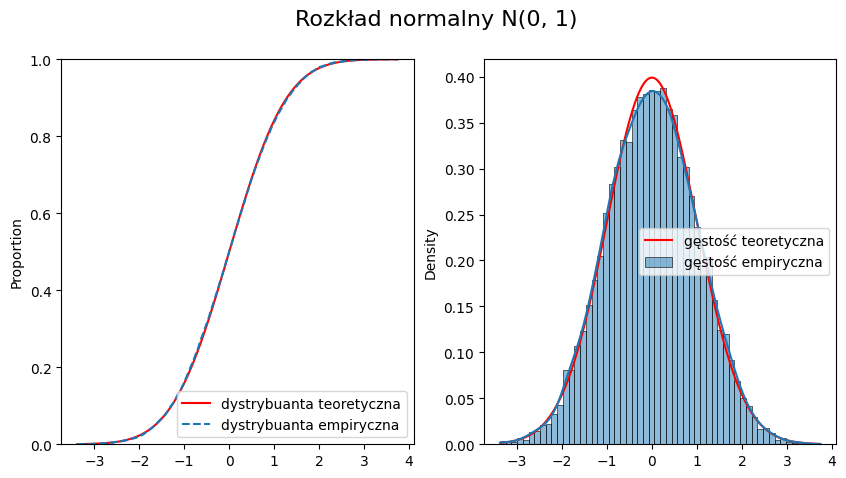

Czas wygenerowania 10000 próbek dla metody tuzina to: 0.19575600000098348 s


In [118]:
def generator_tuzin(n):
    generated_tuzin = np.zeros(n)
    for i in range(n):
        generated_tuzin[i] = tuzin(mu, sigma)
    return generated_tuzin
time_tuzin = timeit.timeit(lambda: generator_tuzin(n), number = 1)
tuzin_sample = generator_tuzin(n)
plot_pdf_cdf(tuzin_sample)
print('Czas wygenerowania {} wartości dla metody tuzina to:'.format(n),time_tuzin,'s' )

#### 2. Metoda zigguratu.
Jako drugą zaimplementowano funkcję, która stworzy próbkę z rozkładu normnalnego za pomocą metody zigguratu. Następnie zostanie zmierzony czas generowania próbki za jej pomocą oraz zostaną stworzone odpowiednie wykresy.

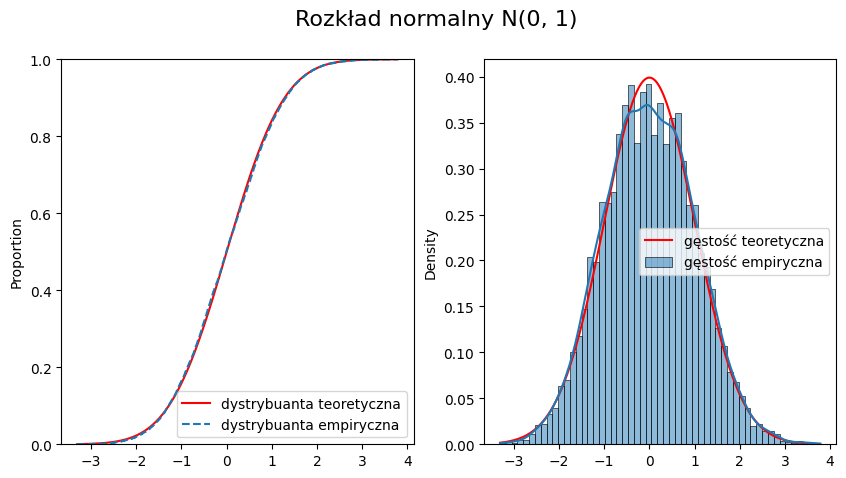

Czas wygenerowania 10000 próbek dla metody zigguratu to: 0.1302947000367567 s


In [126]:
def ziggurat(n):
   # Liczba warstw Ziggurata
    m = 256
    
    # Inicjalizacja tabeli z warstwami
    layers = np.zeros((m, 2))
    
    # Początkowe wartości dla pierwszej warstwy
    x1 = 3.6541528853610088
    y1 = np.exp(-x1**2 / 2)
    layers[0, 0] = x1
    layers[0, 1] = y1
    
    # Obliczenie pola ogona za pomocą metody kwadratury
    tail_area = norm.sf(x1)
    
    # Obliczenie stałej A
    A = x1 * y1 + tail_area
    
    # Wypełnienie tabeli z warstwami
    for i in range(1, m):
        layers[i, 1] = layers[i-1, 1] + A / layers[i-1, 0]
        layers[i, 0] = np.sqrt(-2 * np.log(layers[i, 1]))
    
    # Inicjalizacja wektora wynikowego
    Xs = np.zeros(n)
    
    # Generacja próbek
    for i in range(n):
        while True:
            index = int(np.floor(m * np.random.uniform()))
            if index == m:
                index = m - 1  # Ograniczenie index do m-1, jeśli index == m
            U0 = 2 * np.random.uniform() - 1
            if index == 0:
                x = U0 * A / layers[0, 1]
            else:
                x = U0 * layers[index, 0]
            if np.abs(x) < layers[index, 0]:
                Xs[i] = x
                break
            if index == 0:
                while True:
                    x = -np.log(np.random.uniform()) / layers[0, 0]
                    y = -np.log(np.random.uniform())
                    if 2 * y > x**2:
                        Xs[i] = x + layers[0, 0]
                        break
                break
            else:
                y = layers[index, 1] * np.random.uniform() * (layers[index + 1, 1] - layers[index, 1])
                if y < np.exp(-x**2 / 2):
                    Xs[i] = x
                    break
    
    return Xs * sigma + mu

time_zigg = timeit.timeit(lambda: ziggurat(n), number = 1)
generated_ziggurat = ziggurat(n)
plot_pdf_cdf(generated_ziggurat)
print('Czas wygenerowania {} wartości dla metody zigguratu to:'.format(n),time_zigg,'s' )

#### 3. Generator wbudowany w pakiet Numpy
Jako ostatni zostanie sprawdzony generator wbudowany w pakiet Numpy, aby porównać jego funkcjonowanie z metodami zaimplementowanymi wcześniej. Dla niego również zostanie zmierzony czas oraz narysowane zostaną odpowiednie wykresy.

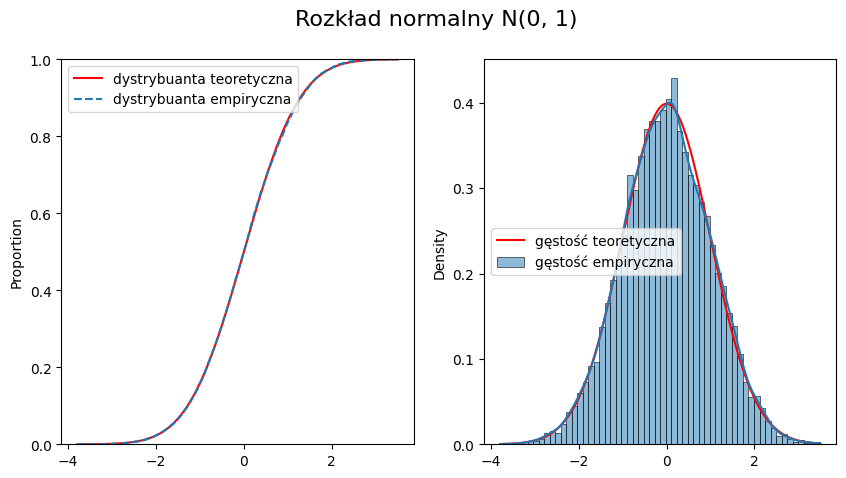

Czas wygenerowania 10000 próbek dla generatora numpy to: 2.300017513334751e-06 s


In [127]:
generated_numpy = np.random.normal(mu,sigma,size = n)
time_np = timeit.timeit(lambda: generated_numpy, number = 1)
plot_pdf_cdf(generated_numpy)
print('Czas wygenerowania {} wartości dla generatora numpy to:'.format(n),time_np,'s' )

## Porównanie dokładności i czasu każdej z metod
Dokładność zostanie zmierzona poprzez wyliczenie średniej arytmetycznej próbki oraz jej wariancji. Następnie policzony zostanie błąd średniej oraz wariancji. Wszystkie dane zostaną wypisane w tabelce. Poniżej znajduje się również wykresy słupkowe ukazujące błędy średniej oraz wariancji wszystkich sprawdzonych metod.

,Method,Mean,Variance,Time,Error (Mean),Error (Variance)
1,Metoda odwrotnej dystrybuanty,-0.028362,1.001199,0.000908,0.028362,0.001199
2,Metoda Boxa-Mullera,0.008807,0.999522,0.002530,0.008807,0.000478
3,Metoda biegunowa B-M,-0.006708,0.994432,0.179952,0.006708,0.005568
4,Przyspieszona metoda bieguniowa B-M,-0.019746,0.994850,0.149581,0.019746,0.005150
5,Metoda tuzina,0.000333,1.006755,0.195756,0.000333,0.006755
6,Metoda Zigguratu,0.005521,1.008594,0.130295,0.005521,0.008594
7,Generator Numpy,0.003300,0.997057,0.000002,0.003300,0.002943


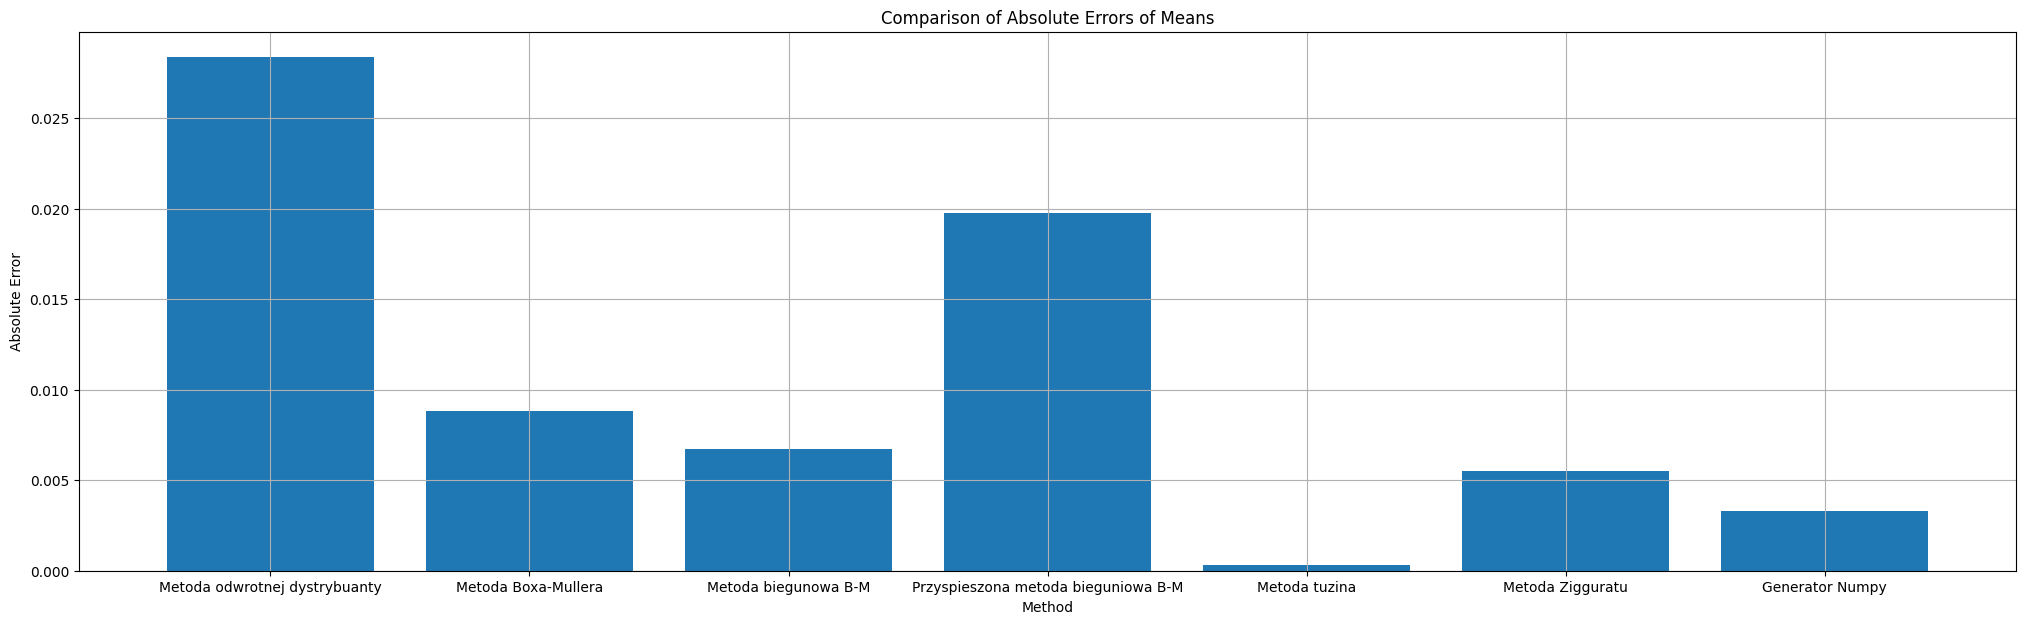

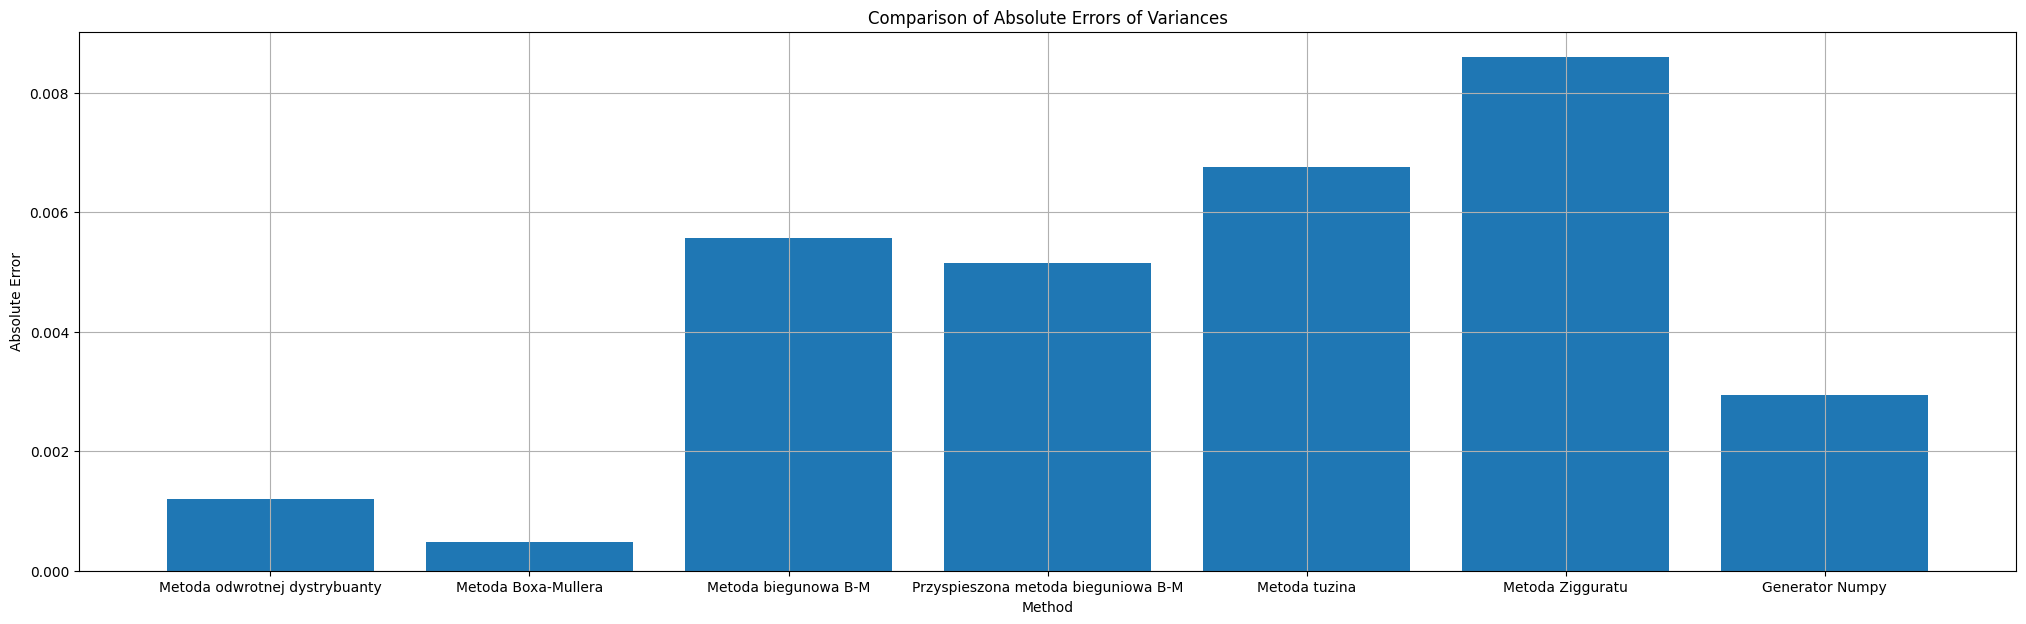

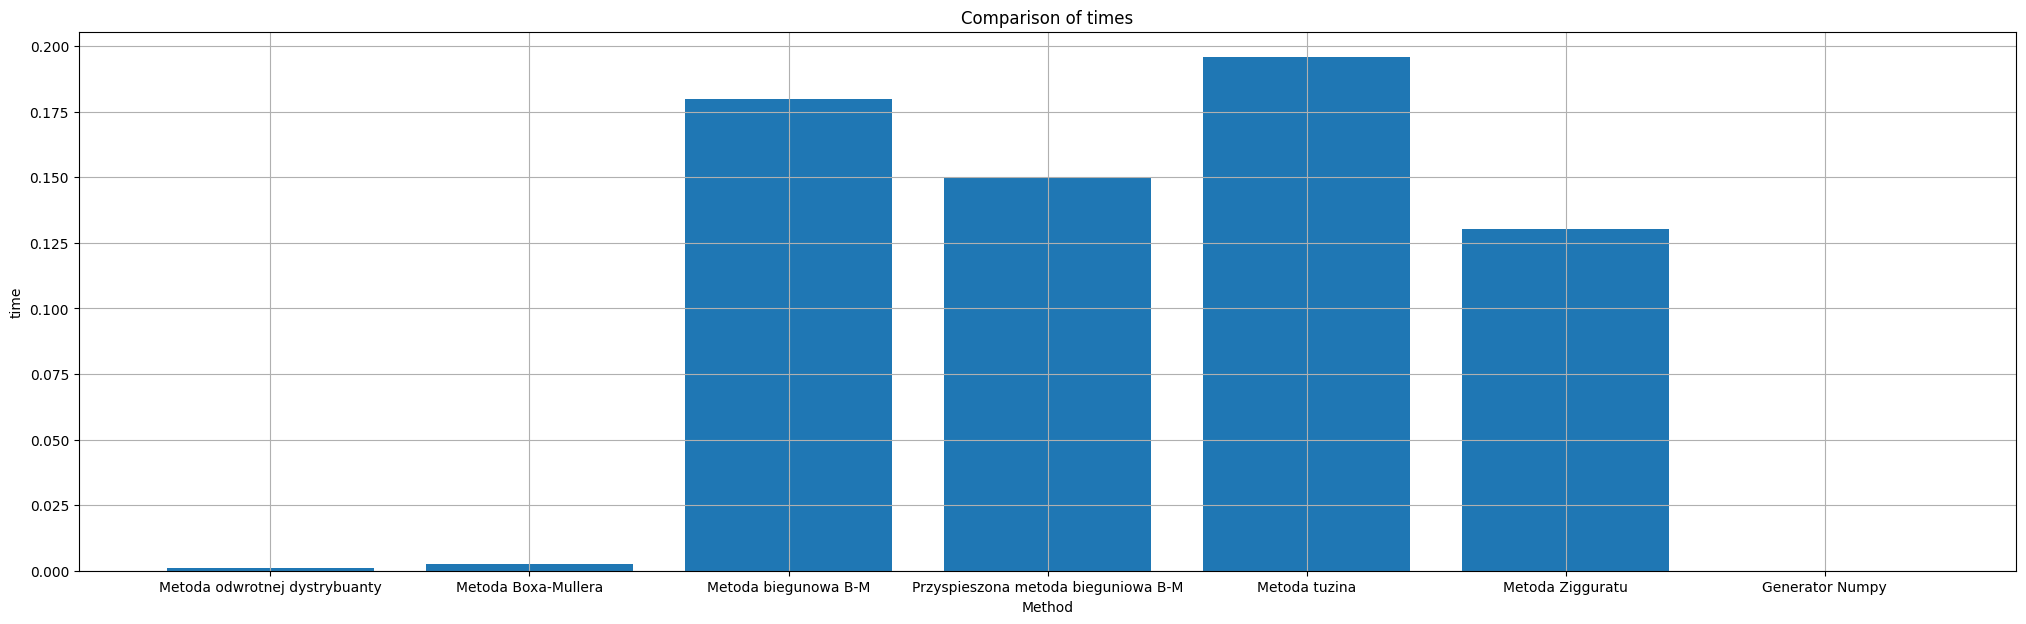

In [130]:
mean_np = np.mean(generated_numpy)
mean_1 = np.mean(generated_normal)
mean_box_muller = np.mean(x1)
mean_polar_box_muller = np.mean(x2)
mean__fast_polar_box_muller = np.mean(x3)
mean_tuzin = np.mean(tuzin_sample)
mean_ziggurat = np.mean(generated_ziggurat)

var_np = np.var(generated_numpy)
var_1 = np.var(generated_normal)
var_box_muller = np.var(x1)
var_polar_box_muller= np.var(x2)
var__fast_polar_box_muller = np.var(x3)
var_tuzin = np.var(tuzin_sample)
var_ziggurat = np.var(generated_ziggurat)


names = ['Metoda odwrotnej dystrybuanty','Metoda Boxa-Mullera','Metoda biegunowa B-M','Przyspieszona metoda bieguniowa B-M','Metoda tuzina','Metoda Zigguratu','Generator Numpy']
means = [mean_1,mean_box_muller,mean_polar_box_muller,mean__fast_polar_box_muller,mean_tuzin,mean_ziggurat,mean_np]
variances = [var_1,var_box_muller,var_polar_box_muller,var__fast_polar_box_muller,var_tuzin,var_ziggurat,var_np]
times = [time1,time_box_muller,time_polar_box_muller,time_fast_box_muller,time_tuzin, time_zigg,time_np]

errors_mean = []
errors_var = []
for mean in means:
    errors_mean.append(abs(mean - mu))

for var in variances:
    errors_var.append(abs(var - sigma))


data = {
    'Method': names,
    'Mean': means,
    'Variance': variances,
    'Time': times,
    'Error (Mean)': errors_mean,
    'Error (Variance)': errors_var
}


df = pd.DataFrame(data)
df.index = df.index + 1
display(df)

plt.figure(figsize=(25,7))
plt.bar(names,errors_mean)
plt.title("Comparison of Absolute Errors of Means")
plt.xlabel("Method")
plt.ylabel("Absolute Error") 
plt.grid(True)
plt.show()

plt.figure(figsize=(25,7))
plt.bar(names,errors_var)
plt.title("Comparison of Absolute Errors of Variances")
plt.xlabel("Method")
plt.ylabel("Absolute Error") 
plt.grid(True)
plt.show()

plt.figure(figsize=(25,7))
plt.bar(names,times)
plt.title("Comparison of times")
plt.xlabel("Method")
plt.ylabel("time") 
plt.grid(True)
plt.show()



## Wnioski
Po porównaniu wykresów oraz analizie wyników testów generowania próbek z rozkładu normalnego, możemy stwierdzić, że wszystkie badane metody są skuteczne w generowaniu próbek z tego rozkładu. Dla odpowiednio dużej liczby próbek, wykresy dystrybuant empirycznych oraz gęstości empirycznych są praktycznie identyczne z ich teoretycznymi odpowiednikami.

Analizując tabelę porównawczą oraz wykresy słupkowe, możemy zauważyć, że wbudowany generator w pakiecie NumPy wyróżnia się jako najszybszy spośród badanych metod. Metody oparte na odwrotnej dystrybuancie oraz Boxa-Mullera również prezentują się dobrze, chociaż ich szybkość generowania próbek jest nieco mniejsza.

Niektóre z metod wykazują nieznacznie większe błędy średniej i wariancji, jednakże są one na tyle małe, że nie mają istotnego wpływu na analizę rozkładu normalnego.

Ostatecznie, najlepszym wyborem spośród badanych generatorów okazuje się być wbudowana funkcja w pakiecie NumPy. Jest to spowodowane jej szybkością oraz niewielkimi błędami średniej i wariancji. Drugim najlepszym wyborem jest metoda Boxa-Mullera, ze względu na szybkość generowania próbek i niewielkie błędy.

Podsumowując, zarówno wbudowany generator w NumPy, jak i metoda Boxa-Mullera, są godnymi polecenia rozwiązaniami do generowania próbek z rozkładu normalnego, uwzględniając zarówno ich szybkość, jak i dokładność.


___
# $\text{Zadanie 3 - Metody redukcji wariancji.}$

## Krok 1 - metodą Monte Carlo oblicz całkę 
$$
\int_0^1 \frac{4}{1 + x^2} \, dx
$$
(szacowanie liczby $\pi$).

In [287]:
def monte_carlo_integrate(func, a, b, num_points):
    x_samples = np.random.uniform(a, b, num_points)

    f_x = func(x_samples)
    average = np.mean(f_x)

    return average * (b - a)

def func(x):
    return 4 / (1 + x ** 2)

a = 0
b = 1
n = 10000
result = monte_carlo_integrate(func, a, b, n)
print("Wynik Monte Carlo:", result)


Wynik Monte Carlo: 3.144039795422364


### Krok 2 - stosujemy metodę redukcji wariancji do ponownego obliczenia zadanej całki. 
 My wybieramy metodę odbić lustrzanych - antithetic variates.

In [24]:
def monte_carlo_antithetic(func, a, b, num_points):
    x_samples = np.random.uniform(a, b, num_points)
    # Obliczamy odbicia lustrzane dla x
    x_mirror = b + a - x_samples
    
    f_x = func(x_samples)
    f_x_mirror = func(x_mirror)
    
    average = np.mean((f_x + f_x_mirror) / 2)
    
    return average * (b - a)

result_antithetic = monte_carlo_antithetic(func, a, b, n)
print("Wynik Monte Carlo za pomocą metody odbić lustrzanych:", result_antithetic)


Wynik Monte Carlo za pomocą metody odbić lustrzanych: 3.1406576474516292


### Krok 3 - analiza błędu względem ilości symulacji dla obu metod.

In [89]:
sample_sizes = [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 75000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]

results_antithetic = {"Sample Size": [], "MC Estimate (Antithetic)": [], "Absolute Error (Antithetic)": []}
results_plain_mc = {"Sample Size": [], "MC Estimate (Plain)": [], "Absolute Error (Plain)": []}

for n in sample_sizes:
    estimate_antithetic = monte_carlo_antithetic(func, 0, 1, n)
    absolute_error_antithetic = np.abs(estimate_antithetic - np.pi)
    results_antithetic["Sample Size"].append(n)
    results_antithetic["MC Estimate (Antithetic)"].append(estimate_antithetic)
    results_antithetic["Absolute Error (Antithetic)"].append(absolute_error_antithetic)

    estimate_plain = monte_carlo_integrate(func, 0, 1, n)
    absolute_error_plain = np.abs(estimate_plain - np.pi)
    results_plain_mc["Sample Size"].append(n)
    results_plain_mc["MC Estimate (Plain)"].append(estimate_plain)
    results_plain_mc["Absolute Error (Plain)"].append(absolute_error_plain)

results_df = pd.DataFrame(results_antithetic)
results_plain_mc_df = pd.DataFrame(results_plain_mc)
comparison_df = pd.merge(results_plain_mc_df, results_df, on="Sample Size")
comparison_df.index = comparison_df.index + 1
comparison_df

,Sample Size,MC Estimate (Plain),Absolute Error (Plain),MC Estimate (Antithetic),Absolute Error (Antithetic)
1,100,3.158393,0.016800,3.138204,3.388749e-03
2,200,3.132058,0.009535,3.143325,1.732135e-03
3,300,3.118761,0.022832,3.142580,9.870829e-04
4,400,3.142948,0.001355,3.144044,2.451273e-03
5,500,3.159493,0.017900,3.138004,3.588955e-03
6,1000,3.146909,0.005316,3.143325,1.732141e-03
7,2000,3.140060,0.001533,3.140990,6.030290e-04
8,3000,3.149773,0.008180,3.142302,7.092420e-04
9,4000,3.138784,0.002809,3.139788,1.804500e-03
10,5000,3.150005,0.008413,3.142109,5.160973e-04


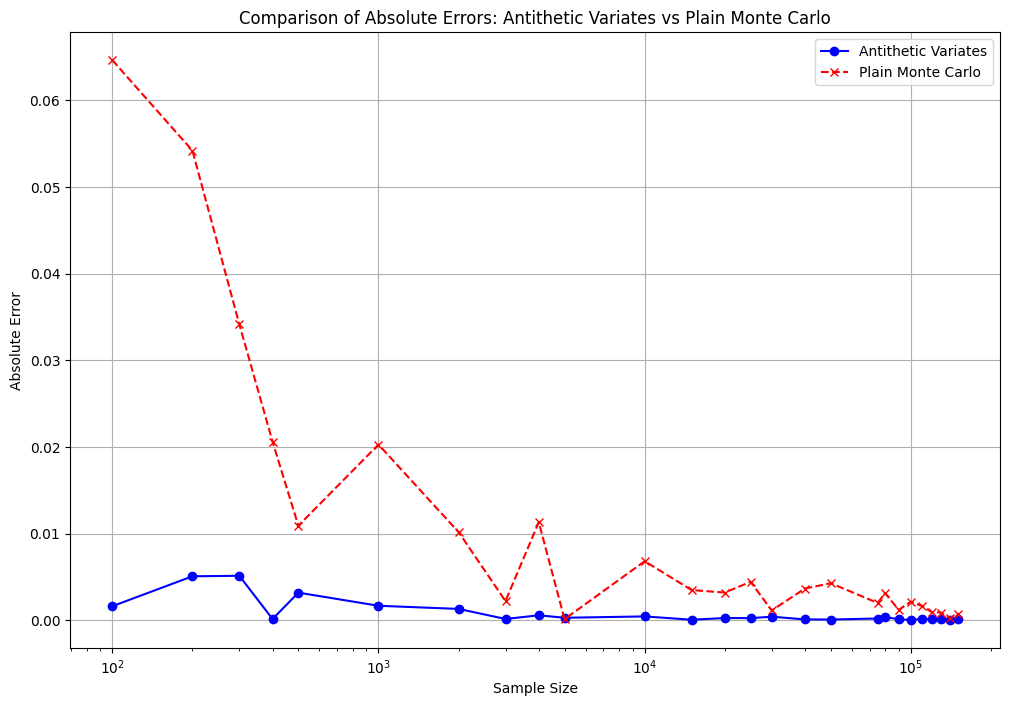

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(comparison_df["Sample Size"], comparison_df["Absolute Error (Antithetic)"], marker='o', linestyle='-', color='b', label='Antithetic Variates')
plt.plot(comparison_df["Sample Size"], comparison_df["Absolute Error (Plain)"], marker='x', linestyle='--', color='r', label='Plain Monte Carlo')
plt.title("Comparison of Absolute Errors: Antithetic Variates vs Plain Monte Carlo")
plt.xlabel("Sample Size")
plt.ylabel("Absolute Error")
plt.xscale("log")  
plt.legend()
plt.grid(True)
plt.show()

### Wnioski z analizy porównawczej metod Monte Carlo
#### 1. Skuteczność metody redukcji wariancji
Metoda z odbiciami lustrzanymi konsekwentnie generuje mniejsze błędy bezwzględne na wszystkich poziomach próbkowania. Pokazuje to wyraźnie skuteczność tej metody w redukcji wariancji w porównaniu do standardowej metody Monte Carlo.

#### 2. Stabilność metod
Metoda z odbiciami lustrzanymi wykazuje znacznie mniejsze fluktuacje błędów między różnymi poziomami próbkowania, co sugeruje większą stabilność tej metody w różnych warunkach symulacyjnych.

#### 3. Efektywność w zastosowaniach
Wyższa precyzja metody z odbiciami lustrzanymi może być decydująca w zastosowaniach wymagających wysokiej dokładności obliczeń.

#### Podsumowanie
Metoda Monte Carlo z odbiciami lustrzanymi jest preferowanym wyborem, gdy kluczowe jest zmniejszenie wariancji i zwiększenie precyzji estymacji. Mimo iż wymaga ona nieco większego nakładu obliczeniowego przez konieczność generowania par przeciwdziałających sobie próbek, korzyści wynikające z jej stosowania w znacznym stopniu przeważają nad dodatkowymi kosztami, szczególnie w aplikacjach wymagających dokładności.

___
## $\text{Zadanie 4 - warunkowa wartość oczekiwana.}$

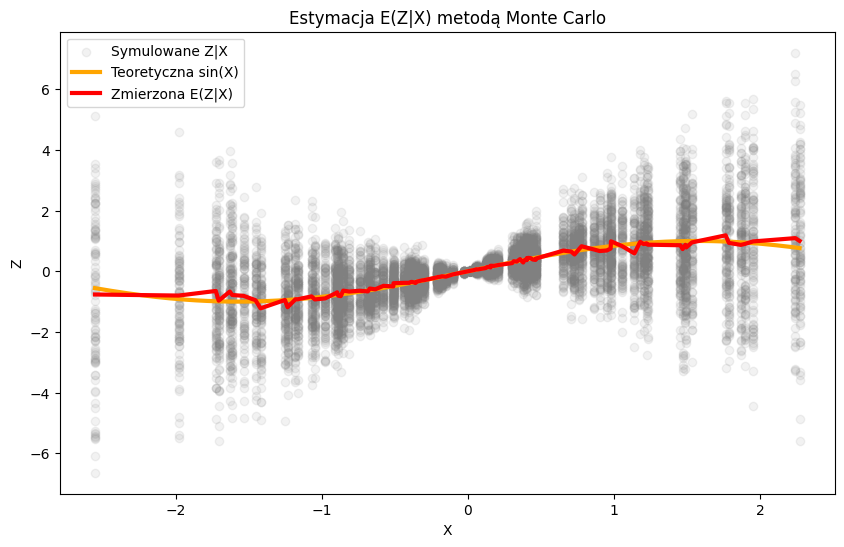

In [1]:
np.random.seed(0)

n = 100 
M = 100 

X = np.random.normal(0, 1, n)
X = np.unique(X) 
X = np.sort(X)
n = len(X) 

Z_values = np.zeros(n * M)
X_values = np.repeat(X, M)

for i, x_i in enumerate(X):
    Y = np.random.normal(0, 1, M) 
    Z_values[i * M:(i + 1) * M] = x_i * Y + np.sin(x_i)  

Z_means = np.array([np.mean(Z_values[i * M:(i + 1) * M]) for i in range(n)])

x_range = np.linspace(np.min(X), np.max(X), 300)

plt.figure(figsize=(10, 6))
plt.scatter(X_values, Z_values, color='gray', alpha=0.1, label='Symulowane Z|X')
plt.plot(x_range, np.sin(x_range), color='orange', label='Teoretyczna sin(X)', linewidth=3)
plt.plot(X, Z_means, color='red', label='Zmierzona E(Z|X)', linewidth=3)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Estymacja E(Z|X) metodą Monte Carlo')
plt.legend()
plt.show()

___ 
# $ \text{Zadanie 5 - Czas ruiny} $
Niech $X_t$ będzie procesem ruiny modelu Craméra-Lundberga
$$
    X_t = u + ct − \sum _{i=0}^{N_t} ξ_i,
$$
gdzie $ t,c,u ≥ 0, ξ_i ∼ \text{Exp}(η), ξ_i$ ⊥ $ξ_j$ dla $i \neq j, \mathrm{E}(ξ_i) = η, $ a $N_t$ jest procesem Poissona o intensywności λ. Czasem
ruiny klasycznej nazywamy zmienną τ = inf{ t > 0 | Xt < 0 }. Prawdopodobieństwem ruiny w czasie nieskończonym
nazywamy funkcję ψ(u,c) = P (τ < ∞). Wzór Pollaczka-Chinczyna mówi, że
$$
ψ(u, c) =\frac{ηλ}{c} e^{−(\frac{1}{η} − \frac{\lambda}{c})u},
$$
Zweryfikowano symulacyjnie ten wynik. W tym celu skorzystano z pomocniczego prawdopodobieństwa ruiny w czasie skończonym T, tj. Ψ(u,c,T) = P (τ < T), T > 0, dla odpowiednio dużego T. Aby to uzyskać przeprowadzono symulację metodą Monte Carlo. 
Na początku ustalono potrzebne parametry oraz ilość symulacji.

In [288]:
T_horizon = 10
lambda_ = 1
eta = 1
MC = 1000

Następnie zaimplementowano funkcję, która zasymuluje proces ruiny.

In [289]:
def simulate_ruin(u, c):
    time = 0
    while time <= T_horizon:
        t = np.random.exponential(1/lambda_)
        time += t
        loss = np.random.exponential(1/eta)
        u = u + c*t - loss
        if u <= 0:
            return 1
    return 0


Kolejnym krokiem było zaimplementowanie funkcji, która obliczy prawdopodobieństwo zgodnie ze wzorem Pollaczka-Chinczyna.

In [290]:
def pollaczek_chinczyn(u,c):
    return ((eta*lambda_)/c) * np.exp(-( (1/eta) - (lambda_/c) )* u) 

Następnie zaimplementowano funkcję, która obliczy prawdopodobieństwo ruiny.

In [295]:
def probability(u,c):
    if c <= lambda_ * eta:
        return 1
    ruins = [simulate_ruin(u, c) for _ in range(MC)]
    return  np.mean(ruins)

Jako pierwsze zostaną obliczone prawdopodobieństwa ruiny dla stałych wartościach wskaźnika przyrostu i zmiennych kapitałach początkowych. Do zobrazowania wyników przyjęto $c \in \{2,5,10\} $ oraz 100 wartości u z przedziału [1,20]. 

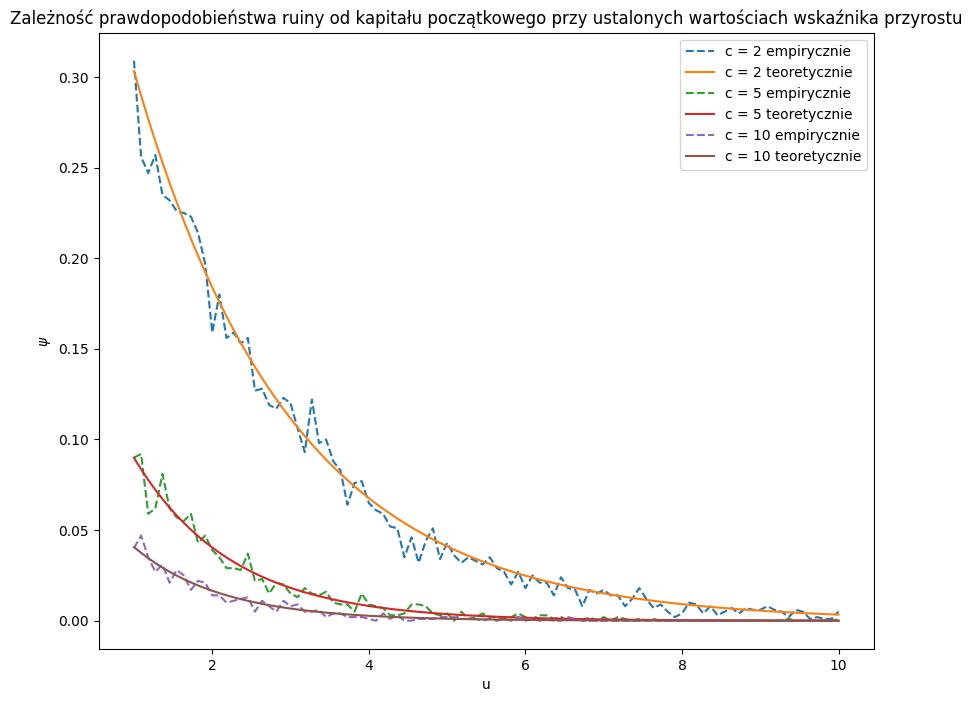

In [296]:
income = [2, 5, 10] 
initial_capital = np.linspace(1,10,100)

plt.figure(figsize=(10,8))
for c in income:
    probabilities = []
    teo_prob = []
    for u in initial_capital:
        p = probability(u,c)
        probabilities.append(p)
        pc = pollaczek_chinczyn(u,c)
        teo_prob.append(pc)
    plt.plot(initial_capital,probabilities,label = f'c = {c} empirycznie',linestyle='--')
    plt.plot(initial_capital,teo_prob,label = f'c = {c} teoretycznie')
plt.legend()
plt.title("Zależność prawdopodobieństwa ruiny od kapitału początkowego przy ustalonych wartościach wskaźnika przyrostu")
plt.xlabel("u")
plt.ylabel("$\psi$")
plt.show()

Następnie sprawdzono zachowanie prawdopodobieństwa dla stałych kapitałów początkowych, czyli w naszym przypadku $ u \in \{2,5,10\} $ oraz zmiennych wartości wskaźnika przychodów u, którymi będzie 100 liczb z przedziału [2,20].

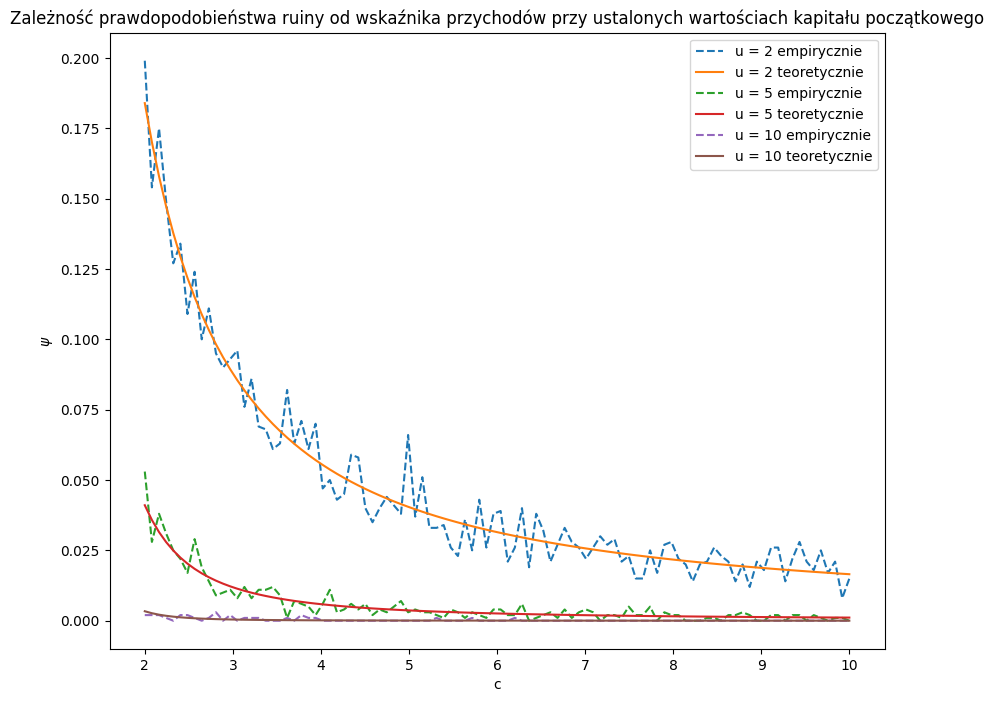

In [297]:
initial_capital = [2, 5, 10] 
income = np.linspace(2,10,100)

plt.figure(figsize=(10,8))
for u in initial_capital:
    probabilities = []
    teo_prob = []
    for c in income:
        p = probability(u,c)
        probabilities.append(p)
        pc = pollaczek_chinczyn(u,c)
        teo_prob.append(pc)
    plt.plot(income,probabilities,label = f'u = {u} empirycznie',linestyle='--')
    plt.plot(income,teo_prob,label = f'u = {u} teoretycznie')
plt.legend()
plt.title("Zależność prawdopodobieństwa ruiny od wskaźnika przychodów przy ustalonych wartościach kapitału początkowego")
plt.xlabel("c")
plt.ylabel("$\psi$")
plt.show()

Analizę powtórzono dla funkcji odwrotnej do funkcji ze wzoru Pollaczka-Chinczyna.
$$
c(u,ψ) = \frac{λu}{W_0 \left(\frac{u \psi e^{uη}}{η} \right)}
$$
gdzie W_0 to gałąź funkcji W Lamberta zdefiniowana poprzez równanie:
$$
 W_0(xe^x) = x \,\,\,\,\, \text{dla} \,\,\, x ≥0 
$$
Analiza ta odpowiada szukaniu wymaganej wartości wpłat przy danym kapitale początkowym w celu osiągnięcia wymaganego prawdopodobieństwa ruiny.
Pierwszym krokiem było zaimplementowanie funkcji $c(u,ψ)$.

In [259]:
def inv_pol_chin(u,psi):
    return np.real((lambda_*u) / (lambertw((u*psi*np.exp(u/eta))/eta)))

Następnie napisano funkcję, która wyliczy wyestymowaną wartość wskaźnika przychodów

In [269]:
"""
NO I TU CHYBA TA FUNKCJA BEDZIE CO NIE BO NARAZIE TO TYLKO TEORETYCZNIE LICZYMY
"""

'\nNO I TU CHYBA TA FUNKCJA BEDZIE CO NIE BO NARAZIE TO TYLKO TEORETYCZNIE LICZYMY\n'

Następnie dla ustalonych wartości prawdopodobieństwa ruiny $\psi$ , które w tym przypadku wynosić będą $\psi \in \{0.3 , 0.5 , 0.9\} $ i zmiennych wartości kapitału początkowego $u$, stworzono wykresy, w celu porównania wartości wyestymowanych z teoretycznymi. 

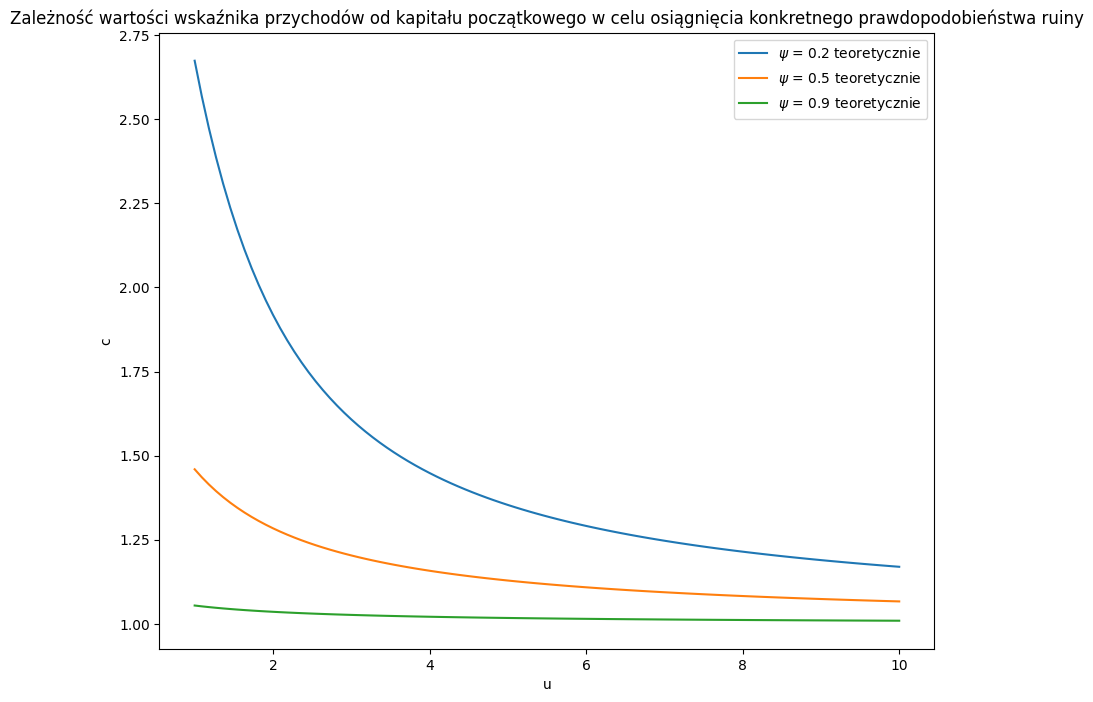

In [294]:
probabilities = [0.2, 0.5, 0.9] 
initial_capital = np.linspace(1,10,100)

plt.figure(figsize=(10,8))
for psi in probabilities:
    teo = []
    for u in initial_capital:
        inv = inv_pol_chin(u,psi)
        teo.append(inv)
    plt.plot(initial_capital, teo, label = f'$\psi$ = {psi} teoretycznie' )
plt.legend()
plt.title("Zależność wartości wskaźnika przychodów od kapitału początkowego w celu osiągnięcia konkretnego prawdopodobieństwa ruiny")
plt.xlabel("u")
plt.ylabel("c")
plt.show()

# Wnioski
Analizując przeprowadzone symulacje oraz stworzone wykresy, można wysunąć wniosek, że zarówno wzór Pollaczka-Chinczyna, jak i jego funkcja odwrotna są poprawne, a wartości empirycznie wyliczone nie różnią się znacząco od wartości teoretycznych.

Wygenerowane wykresy wyraźnie pokazują zależności między prawdopodobieństwem ruiny, kapitałem początkowym oraz współczynnikiem przychodów. Możemy zauważyć, że większy kapitał początkowy prowadzi do zmniejszenia prawdopodobieństwa ruiny, podobnie jak zwiększenie współczynnika przychodów. Dodatkowo, analiza ostatniego wykresu pozwala stwierdzić, że przy rosnącym kapitale początkowym, prawdopodobieństwo ruiny pozostaje stałe, jeśli odpowiednio zmniejszymy współczynnik przychodów.

Wnioski te mogą być używane do podejmowania decyzji zarządczych lub inwestycyjnych w celu optymalizacji wyników finansowych i minimalizacji ryzyka bankructwa. Dzięki analizie tych zależności, można lepiej zrozumieć, jak zmiany w kapitale początkowym i współczynniku przychodów mogą wpływać na stabilność finansową i ryzyko bankructwa. Jest to istotna wiedza przy podejmowaniu decyzji dotyczących alokacji kapitału i zarządzania ryzykiem w różnych dziedzinach biznesowych oraz inwestycyjnych.

___ 
# $\text{Zadanie 6 - Prawa arcusa sinusa}$
Ciągła zmienna losowa X ma rozkład arcusa sinusa $(X \sim \mathrm{Arcsine})$, gdy jej funkcja gęstości prawdopodobieństwa $pX$ ma postać:
$$ 
p_X(x) = \frac{1}{π\sqrt{x(1 −x)}} \mathbb{1}_{(0,1)}(x). 
$$
Dystrybuanta tej zmiennej losowej jest wtedy równa
$$
F_X(x) = 
\begin{cases}
0, \ \ \  x \lt 0, \\
\frac{2}{\pi}\arcsin(\sqrt{x}), \ \ \   x \in [0, 1], \\
1, \ \ \   x \gt 1.
\end{cases}
$$
Poniżej zaimplementowano obie funkcje.

In [26]:
def arc_sin_pdf(x):
    return [0 if xi >= 1 or xi <= 0 else 1/(np.pi * np.sqrt(xi*(1-xi))) for xi in x]


def arc_sin_cdf(x):
    return [0 if xi < 0 else 1 if xi > 1 else (2/np.pi)*np.arcsin(np.sqrt(xi)) for xi in x]
 

Zaimplementowana została również funkcja procesu Wienera $W_t$.

In [27]:
def wiener_process(T, N):
    dt = T / N  
    dW = np.random.normal(0, np.sqrt(dt), N)
    W = np.cumsum(dW)
    W = np.insert(W, 0, 0)  # początkowa wartość W(0) = 0
    return  W

Na początku ustalono parametry, które będą używane w weryfikacji wszystkich trzech praw.

In [36]:
N = 1000
T = 1
MC = 10000
time = np.linspace(0,T,N+1)

W następnej kolejności przystąpiono do weryfikacji praw arcusa sinusa. W tym celu wykorzystujemy metodę Monte Carlo.
## 1. Pierwsze prawo arcusa sinusa

$$
T_+ = \lambda ({ t \in [0, 1][W_t > 0] }) \sim \mathrm{Arcsine}
$$

gdzie $\lambda$ to miara Lebesgue’a. Oznacza to, że czas spędzony przez proces Wienera powyżej osi OX na odcinku [0,1] ma rozkład arcusa sinusa.

Zadanie rozpoczęto od implementacji funkcji, która zwracać będzie czas $T_+$

In [37]:
def wiener_positive(W, t):
    dt = t[1] - t[0]
    W_plus_count = np.count_nonzero(W > 0)
    return W_plus_count * dt

Następnie przystąpiono do przeprowadzenia symulacji i porównania histogramów oraz dystrybuant empirycznych wysymulowanych próbek z teoretycznymi wartościami.

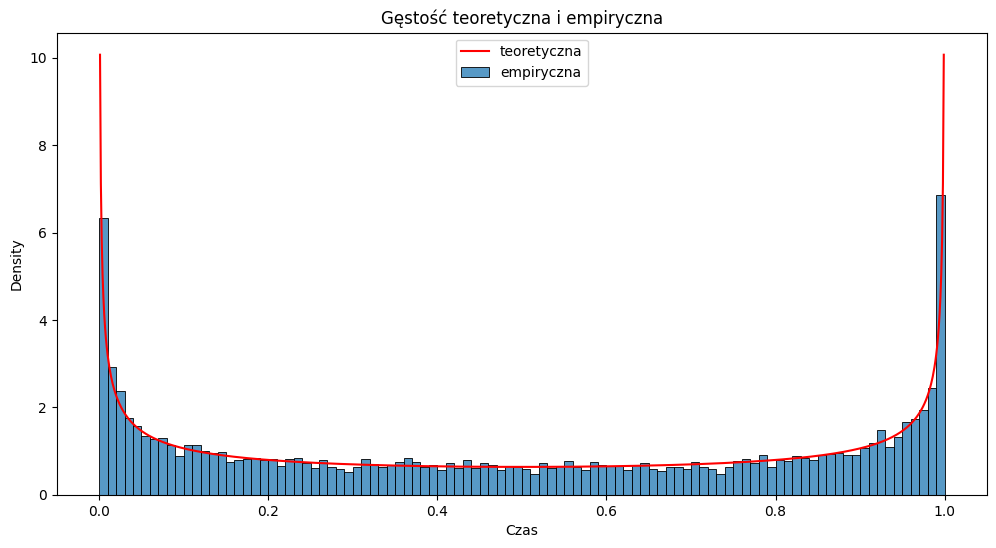

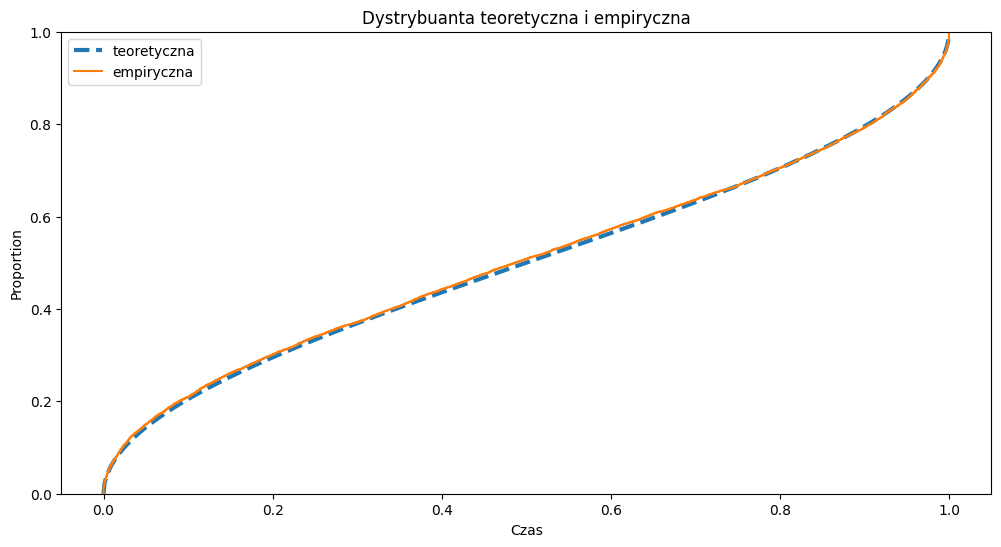

In [58]:
T_positive = []

for _ in range(MC):
    W = wiener_process(T, N)
    T_positive.append(wiener_positive(W, time))


# Gęstość
plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(T_positive, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()

# Dystrybuanta
plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), '--', linewidth=3, label="teoretyczna")
sns.ecdfplot(T_positive, label='empiryczna')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()


## 2. Drugie prawo arcusa sinusa

$$
L = \sup{ \{ t \in [0, 1][W_t = 0] \} } \sim \mathrm{Arcsine}
$$

Inaczej mówiąc, ostatni moment uderzenia procesu Wienera na odcinku [0,1] w oś OX ma rozkład arcusa sinusa.

Na początku zaimplementowano funkcję pozwalającą obliczyć wartość L. Generowany proces Wienera nie jest ciągły, ponieważ jest dyskretyzowany przez czas. Z tego względu nie sprawdzano dla jakiego $t$ $W(t)=0$, ponieważ takie podejście doprowadziłoby nas do błędnych wyników. Zamiast tego sprawdzono, dla jakiego $t$, $W(t)$ i $W(t-\Delta t)$ mają różne znaki. Wtedy korzystając z twierdzenia Darboux jesteśmy pewni, że $ \exists \,x \in [t-\Delta t,t]:\, W(x)=0$. W poniższej symulacji założono, że byłby to moment: $\frac{(t-\Delta t) + t}{2} = t - \frac{\Delta t}{2}$.

In [62]:
def last_hit(W, t):
    dt = t[1] - t[0]
    l = 0
    ps = 1 if W[0] >= 0 else -1

    for i, w in enumerate(W):
        cs = 1 if w >= 0 else -1
        if cs != ps:
            l = i * dt
            ps = cs
    
    return l - dt / 2


Następnie przeprowadzono symulacje i porównano dystrybuanty i gęstości.

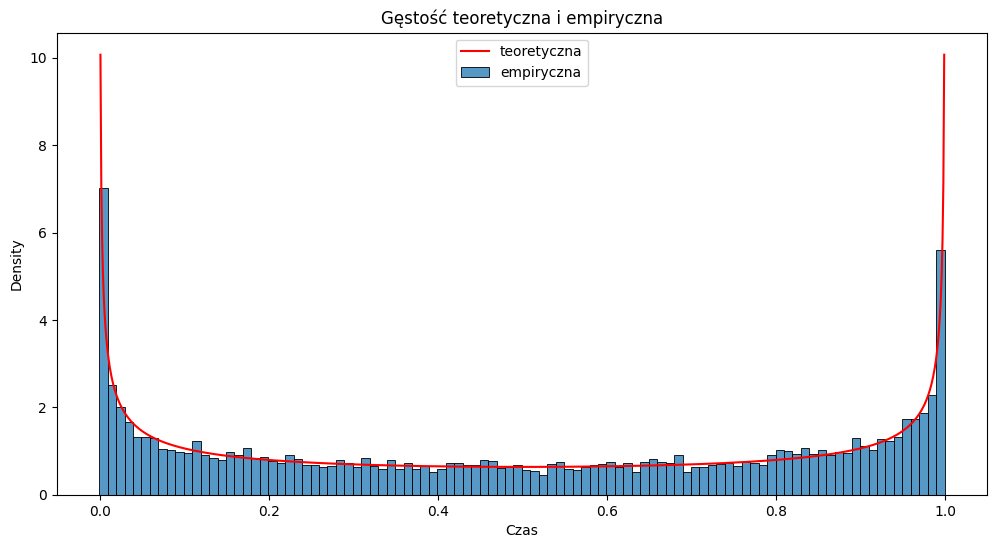

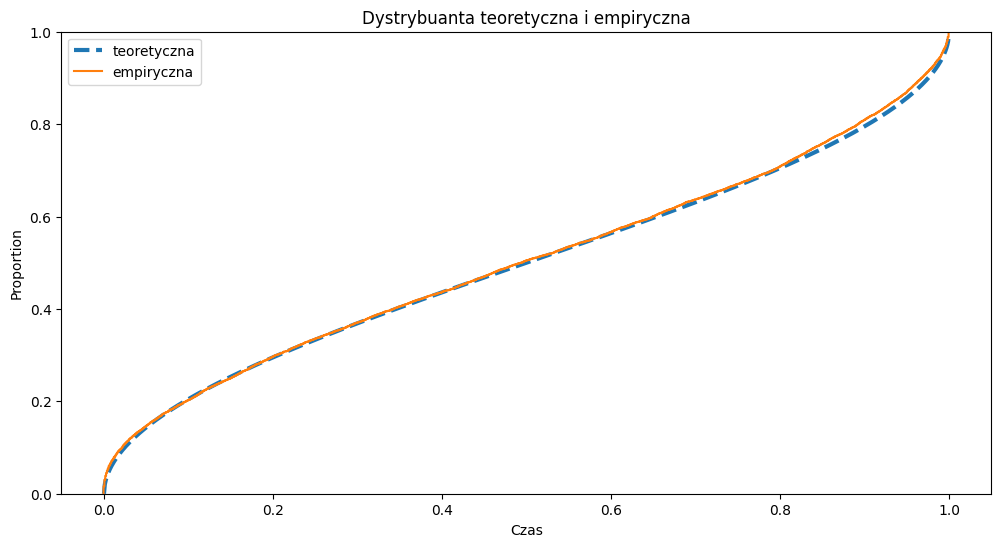

In [67]:
L_values = []
for _ in range(MC):
    W = wiener_process(T, N)
    L_values.append(last_hit(W, time))


plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(L_values, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()

# Dystrybuanta
plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), '--', linewidth=3, label="teoretyczna")
sns.ecdfplot(L_values, label='empiryczna')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()

## 3. Trzecie prawo arcusa sinusa
Niech $M$ będzie liczbą spełniającą:
$$
W_M = \sup{ \{ W_t | t \in [0, 1] \} } \sim \mathrm{Arcsine}.
$$
Wtedy $M \sim  \mathrm{Arcsine}$. Oznacza to, że moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1] ma rozkład arcusa sinusa.

Pierwszym krokiem było zaimplementowanie funkcji, która obliczy wartość M.

In [68]:
def time_of_max(W):
    max_arg = np.argmax(W)
    return time[max_arg]

Na koniec przeprowadzono symulację w celu porównania dystrybuant i gęstości empirycznych z teoretycznymi. 

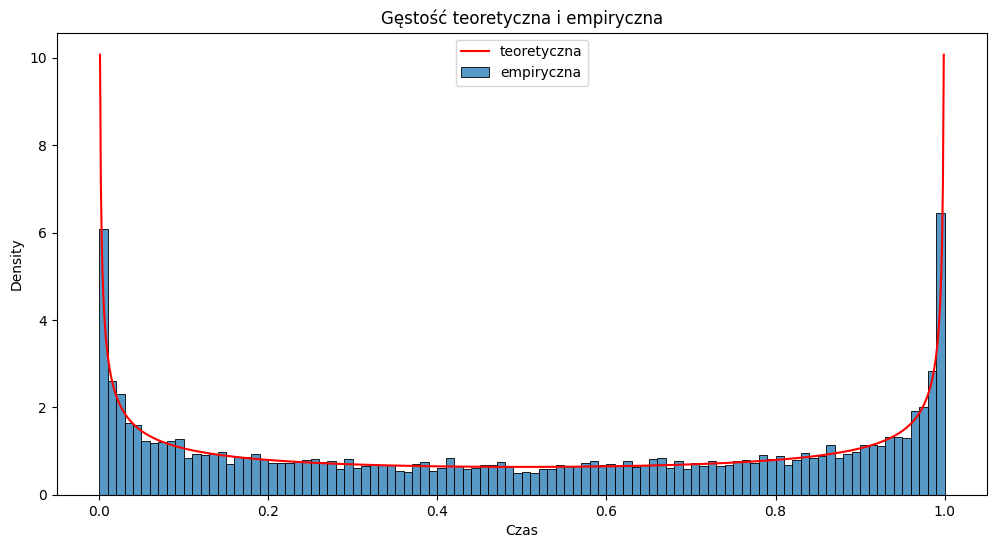

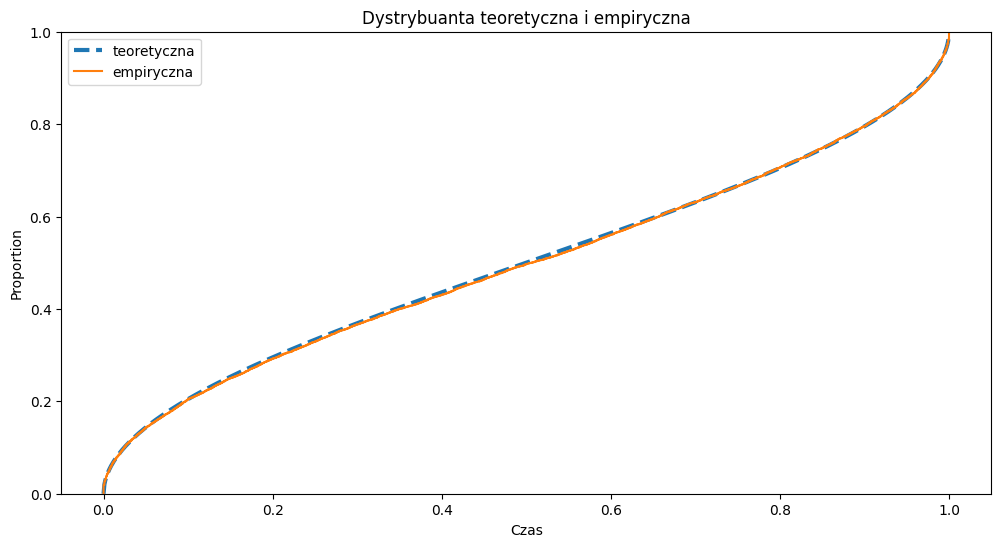

In [70]:
M_values = []
for _ in range(MC):
    W = wiener_process(T, N)
    M_values.append(time_of_max(W))


plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(M_values, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()

# Dystrybuanta
plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), '--', linewidth=3, label="teoretyczna")
sns.ecdfplot(M_values, label='empiryczna')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()

## 4. Wnioski
Analizując wyżej przedstawione wykresy, stwierdzono, że przeprowadzone symulacje są efektywne w odwzorowywaniu teoretycznych zależności dla procesu Winera i rozkładu Arcsine. Odnosząc się do pierwszego, drugiego i trzeciego prawa arcsinusa, możemy potwierdzić, że symulacje są zgodne z teoretycznymi założeniami, co potwierdza ich wiarygodność.
Potwierdzenie tych praw dla przeprowadzonych symulacji jest kluczowe, ponieważ świadczy o poprawności oraz adekwatności zastosowanych metod symulacyjnych do badania tych procesów i rozkładów.

